Correlation analysis in Python to see if 2 variables are correlated to one another or not.

Just a quick note: usually, I would go with Pearson to calculate correlation between *concentrations* of molecules. However, when calculating correlation between cell count and concentration of molecules, I would go with Spearman because *cell count* isn't exactly a *continuous* metric like concentration is, rather it is discrete.

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

Create a Pandas DataFrame with columns for subject and ELISA readouts (as OD 450 nm readout) for Antigen (Ag) A, Ag B, Ag C, Ag D, Ag E, and Ag F.

In [2]:
# Create dataframe using list and zip them all

# Create list, wrap as function as to not pollute globals
def main_list():
    subject_id = ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007']
    ag_A = [1.22, 1.01, 1.04, 1.11, 0.98, 0.99, 1.07]
    ag_B = [0.51, 0.41, 0.33, 0.71, 0.33, 0.61, 0.44]
    ag_C = [0.22, 0.31, 0.10, 0.67, 0.49, 0.77, 0.53]
    ag_D = [0.42, 0.12, 0.17, 0.28, 0.43, 0.21, 0.33]
    ag_E = [0.91, 0.88, 0.91, 1.01, 1.03, 0.87, 0.83]
    ag_F = [0.13, 0.21, 0.20, 0.17, 0.21, 0.23, 0.16]
    
    # zip them all together
    zippedList = zip(subject_id, ag_A, ag_B, ag_C, ag_D, ag_E, ag_F)

    # return zipped list
    return zippedList
    
# Create DataFrame from zipped list
df = pd.DataFrame(main_list(), 
                  columns = ['Subject ID', 'Ag A', 'Ag B', 'Ag C', 'Ag D', 'Ag E', 'Ag F'])

For cursory correlational analysis, I would like to use correlational heatmap. This method is useful for a quick overview because it does provide some visual cue without having to perform 2-axis correlational plot for every single combination, which could take a lot of time.

Thankfully, `DataFrame` object has `.corr()` method to compute pairwise correlation stupidly easily, and it is smart enough to remove non-float datatypes.

In [3]:
# Wrap within a function as to not pollute globals
def correlation_heatmap(data, plot = True, triangle = False):
    # using .corr() to return pairwise correlation, default is Pearson correlation
    _corr = data.corr()
    
    if plot:
        fig, ax = plt.subplots()
        
        # Make it a triangle with masking enabled
        if triangle:
            _matrix_mask = np.triu(_corr)
            sns.heatmap(ax = ax, data = _corr, annot = True, mask = _matrix_mask, 
                        cbar = False, cmap = 'coolwarm', fmt = '.3g')
        
        # Output full square
        if not triangle:
            sns.heatmap(ax = ax, data = _corr, annot = True, cbar = False, cmap = 'coolwarm', fmt = '.3g')
    
    # Just give me the pairwise correlation dataframe
    if not plot:
        return _corr

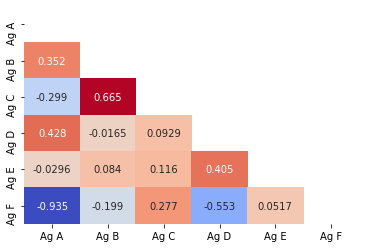

In [4]:
# Return the correlation
correlation_heatmap(df, triangle = True)

Drawing a correlation chart can be done in 2 ways: using `sns.regplot()`, which is automated and really great way to save time but you lose customization ability, or manually by first drawing the dots with pure Matplotlib, then compute the linear equation with `np.polyfit` to later draw a regression line. Great way to further customize the dots, and the great alternative to `sns.regplot()` since it does not accept hue. However, `sns.regplot()` comes with uncertainty boundary, which is difficult to implement simply with pure Matplotlib approach.

In [5]:
# Wrapper function!
def plot_correlator(df, antigen_1 = None, antigen_2 = None, draw_method = 'seaborn', stats = False):
    """
    Plot that correlation!
    
    Arguments:
      draw_method : Default to seaborn, consult sns.regplot documentation for more details.
                  : Use 'matplotlib' to use pure matplotlib approach with np.polyfit()
                  : Use 'no_plot' if not drawing to return dataframe
      stats       : if True, print Pearson R stats
    """ 
    
    # Plot with sns.regplot
    if draw_method == 'seaborn':
        fig, ax = plt.subplots()
        sns.regplot(data = df, x = antigen_1, y = antigen_2)
        
    # Plot with matplotlib, first get Pandas series
    _ag1 = df[antigen_1]
    _ag2 = df[antigen_2]
    
    # Calculate straight line equation with np.polyfit
    m, b = np.polyfit(_ag1, _ag2, 1)
    
    # Draw the plot
    if draw_method == 'matplotlib':
        fig, ax = plt.subplots()
        ax.plot(_ag1, _ag2, marker = 'o', linestyle = '')        # the samples
        ax.plot(_ag1, m*_ag1 + b, linewidth = .2, color = 'red') # the regression line
    
    # Calculate & print stats
    if stats:
        _corr = scipy.stats.spearmanr(_ag1, _ag2)
        ax.set_title(f'r = {round(_corr[0],3)}, p = {round(_corr[1],3)}')
    
    # Return dataframe when using draw_method = 'no_plot'
    if draw_method == 'no_plot':
        return _melted

With the code above defined, now we can run correlation analysis.

First with `seaborn`, then with `matplotlib` and `np.polyfit`.

Watch out the y-axis scale between the two plots!!

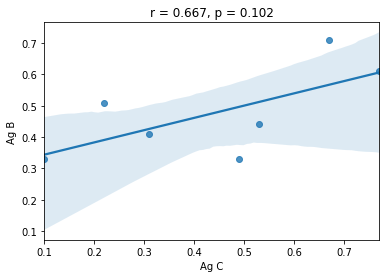

In [6]:
plot_correlator(df, antigen_1 = 'Ag C', antigen_2 = 'Ag B', draw_method = 'seaborn', stats = True)

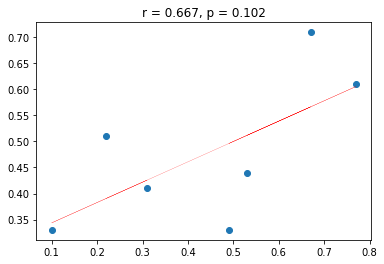

In [7]:
plot_correlator(df, antigen_1 = 'Ag C', antigen_2 = 'Ag B', draw_method = 'matplotlib', stats = True)

Unfortunately, this version with `matplotlib` does not include confidence interval band. So, I wrote a function (inspired by Erik Bernhardsson's [post on uncertainty estimates](https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html)), and that whole script is available in the `scripts` directory. 

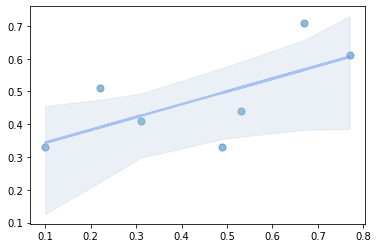

In [8]:
# Import the function
from scripts.linear_reg import lin_reg_plot as lrp

# Instantiate Fig and Axes object
fig, ax = plt.subplots()

# Draw the plot with confidence interval curve off
lrp(ax=ax, data=df, x_var="Ag C", y_var="Ag B")